(1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
import math
import random
import unicodedata
import re
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import OneCycleLR

# Data acquisition

In [ ]:

base_path = '/kaggle/input/rekhta-dataset/dataset'
pairs = []

for poet in os.listdir(base_path):
    poet_path = os.path.join(base_path, poet)
    if not os.path.isdir(poet_path):
        continue

    en_path = os.path.join(poet_path, 'en')
    ur_path = os.path.join(poet_path, 'ur')

    if os.path.exists(en_path) and os.path.exists(ur_path):
        en_files = sorted(os.listdir(en_path))
        ur_files = sorted(os.listdir(ur_path))

        for i, (en_file, ur_file) in enumerate(zip(en_files, ur_files)):
            en_full = os.path.join(en_path, en_file)
            ur_full = os.path.join(ur_path, ur_file)

            with open(en_full, 'r', encoding='utf-8') as f_en, open(ur_full, 'r', encoding='utf-8') as f_ur:
                roman_text = f_en.read().strip()
                urdu_text = f_ur.read().strip()

            if urdu_text and roman_text:
                pairs.append((urdu_text, roman_text, poet))  # Add poet as third element


df = pd.DataFrame(pairs, columns=['urdu', 'roman', 'poet'])
df.to_csv('/kaggle/working/dataset_extracted.csv', index=False, encoding='utf-8')
print(f"Extracted {len(df)} pairs")
print("done")

In [ ]:
print(df.shape)
print("done")

## Data Cleaning

In [ ]:
# read dataset_extracted
df = pd.read_csv('/kaggle/working/dataset_extracted.csv', encoding='utf-8')

In [ ]:
# Cleaning functions
def clean_urdu(text):
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'[^\u0600-\u06FF\s\n]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_roman(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\n]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning directly to existing columns
df['urdu'] = df['urdu'].apply(clean_urdu)
df['roman'] = df['roman'].apply(clean_roman)



# Save the updated DataFrame
df.to_csv('/kaggle/working/cleaned_pairs.csv', index=False, encoding='utf-8')
print("Cleaned Shape:", df.shape)

# Verify Sample
print("\nUrdu Cleaned:\n", df[['urdu']].head(1).to_string())
print("\nRoman Cleaned:\n", df[['roman']].head(1).to_string())

## Tokenization

In [ ]:
CLEANED_PAIRS = 'cleaned/cleaned_pairs.csv'
df = pd.read_csv(CLEANED_PAIRS, encoding='utf-8')
df.head()

In [ ]:
import pandas as pd
import numpy as np
import unicodedata
import re
import json
from collections import Counter

# Load cleaned data
CLEANED_PAIRS = '/content/cleaned_pairs.csv'

def merge_pair(tokens, pair, new_token):
    result = []
    i = 0
    while i < len(tokens):
        if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
            result.append(new_token)
            i += 2
        else:
            result.append(tokens[i])
            i += 1
    return result

def tokens_to_indices(tokens_list, vocab):
    return [[vocab.get(token, len(vocab)) for token in tokens] for tokens in tokens_list]

def save_json(data, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

def clean_roman(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\n]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_char_tokens(text, add_eos=True):
    tokens = list(text.replace(' ', '_'))
    if add_eos:
        tokens.append('<eos>')
    return tokens

def run_bpe(tokens_list, target_vocab_size):
    vocab = Counter([tok for seq in tokens_list for tok in seq])
    merges = []

    while len(vocab) < target_vocab_size:
        pairs = Counter()
        for tokens in tokens_list:
            for i in range(len(tokens) - 1):
                pairs[(tokens[i], tokens[i+1])] += 1

        if not pairs:
            break

        best_pair = max(pairs, key=pairs.get)
        new_token = ''.join(best_pair)
        merges.append((best_pair, new_token))

        tokens_list = [merge_pair(tokens, best_pair, new_token) for tokens in tokens_list]
        vocab[new_token] = pairs[best_pair]

    return tokens_list, vocab, merges

# Urdu tokenization
def clean_urdu(text):
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\u0900-\u097F\s\n]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def improved_get_urdu_tokens(text, add_eos=True):
    words = text.split()
    tokens = []

    for word in words:
        tokens.append('▁')
        for char in word:
            tokens.append(char)

    if add_eos:
        tokens.append('<eos>')
    return tokens

def improved_run_urdu_bpe(tokens_list, target_vocab_size):
    vocab = Counter([tok for seq in tokens_list for tok in seq])
    merges = []

    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
    for token in special_tokens:
        if token not in vocab:
            vocab[token] = 0

    while len(vocab) < target_vocab_size:
        pairs = Counter()
        for tokens in tokens_list:
            for i in range(len(tokens) - 1):
                # Don't merge across word boundaries
                if tokens[i] == '▁' or tokens[i+1] == '▁':
                    continue
                pairs[(tokens[i], tokens[i+1])] += 1

        if not pairs:
            break

        best_pair = max(pairs, key=pairs.get)
        new_token = ''.join(best_pair)
        merges.append((best_pair, new_token))

        tokens_list = [merge_pair(tokens, best_pair, new_token) for tokens in tokens_list]
        vocab[new_token] = pairs[best_pair]

    return tokens_list, vocab, merges


print("Loading data...")
df = pd.read_csv(CLEANED_PAIRS, encoding='utf-8')

print("Cleaning and tokenizing Urdu text with improved method...")
df['urdu'] = df['urdu'].apply(clean_urdu)
urdu_tokens = [improved_get_urdu_tokens(text) for text in df['urdu']]

print("Tokenizing Roman text")
roman_tokens = [get_char_tokens(text) for text in df['roman']]

print(f" BPE for Urdu")
target_vocab_size = 4000
urdu_tokens, urdu_vocab, urdu_merges = improved_run_urdu_bpe(urdu_tokens, target_vocab_size)

print(f"Running standard BPE for Roman...")
roman_tokens, roman_vocab, roman_merges = run_bpe(roman_tokens, 2500)

# Build vocab maps
urdu_vocab_map = {token: idx for idx, token in enumerate(sorted(urdu_vocab.keys()))}
roman_vocab_map = {token: idx for idx, token in enumerate(sorted(roman_vocab.keys()))}

# Convert to indices
urdu_indices = tokens_to_indices(urdu_tokens, urdu_vocab_map)
roman_indices = tokens_to_indices(roman_tokens, roman_vocab_map)

# Save results
df['urdu_tokens'] = [' '.join(tokens) for tokens in urdu_tokens]
df['roman_tokens'] = [' '.join(tokens) for tokens in roman_tokens]
df['urdu_indices'] = urdu_indices
df['roman_indices'] = roman_indices

In [ ]:
df.head()

In [ ]:
print("Saving results...")
save_json(urdu_merges, "/content/urdu_merges_improved.json")
save_json(roman_merges, "/content/roman_merges.json")
save_json(urdu_vocab_map, "/content/urdu_vocab_improved.json")
save_json(roman_vocab_map, "/content/roman_vocab.json")
df.to_csv('/content/tokenized_pairs_improved.csv', index=False, encoding='utf-8')

print(f"Tokenization complete with improved Urdu processing:")
print(f"Urdu vocabulary size: {len(urdu_vocab)}")
print(f"Roman vocabulary size: {len(roman_vocab)}")

# (2)

In [2]:
# Global variables
TOKENIZED_PAIRS = '/content/tokenized_pairs_improved.csv'
# json
URDU_VOCAB = "/content/urdu_vocab_improved.json"
ROMAN_VOCAB = "/content/roman_vocab.json"

URDU_MERGES = '/content/urdu_merges_improved.json'
ROMAN_MERGES = '/content/roman_merges.json'

In [3]:
# Load the tokenized dataset
df = pd.read_csv(TOKENIZED_PAIRS, encoding='utf-8')

import json

# Load urdu vocab
with open(URDU_VOCAB, "r", encoding="utf-8") as f:
    urdu_vocab_map = json.load(f)

# Load roman vocab
with open(ROMAN_VOCAB, "r", encoding="utf-8") as f:
    roman_vocab_map = json.load(f)

with open(URDU_MERGES, "r", encoding="utf-8") as f:
    urdu_merges = json.load(f)

# Load roman vocab
with open(ROMAN_MERGES, "r", encoding="utf-8") as f:
    roman_merges = json.load(f)

In [4]:
def tokenize_inference(text, merges, vocab):
    tokens = list(text.replace(' ', '_'))
    for pair, new_token in merges:
        tokens = merge_pair(tokens, tuple(pair), new_token)
    indices = [vocab.get(token, len(vocab)) for token in tokens]
    return tokens, indices

def merge_pair(tokens, pair, new_token):
    result = []
    i = 0
    while i < len(tokens):
        if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
            result.append(new_token)
            i += 2
        else:
            result.append(tokens[i])
            i += 1
    return result

In [ ]:
print(f"Tokenized {len(df)} pairs with vocabulary size: Urdu={len(urdu_vocab_map)}, Roman={len(roman_vocab_map)}")

Tokenized 1314 pairs with vocabulary size: Urdu=4000, Roman=2500


# Data Preparation

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Using device: {device}")

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

⚡ Using device: cuda


Length Statistics:
          urdu_len    roman_len
count  1314.000000  1314.000000
mean    275.659817   166.714612
std     135.788081    82.838422
min      33.000000    17.000000
25%     187.000000   112.000000
50%     243.000000   147.000000
75%     329.750000   202.000000
max    1067.000000   682.000000


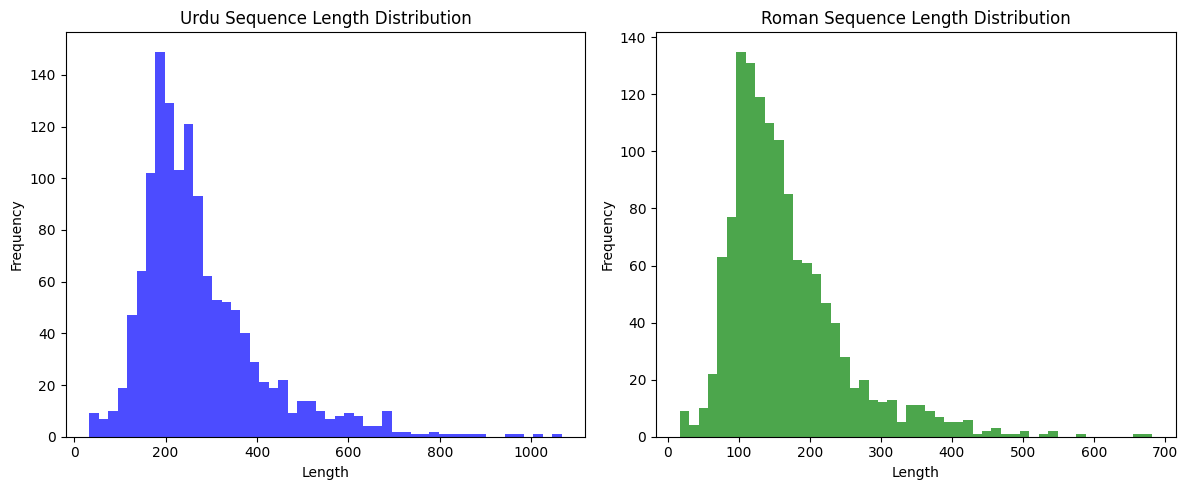

95th percentile for Urdu length: 552.3999999999996
95th percentile for Roman length: 344.0


In [6]:
# Convert string representations of indices back to lists
def parse_indices(indices_str):
    return eval(indices_str) if isinstance(indices_str, str) else indices_str

df['urdu_indices'] = df['urdu_indices'].apply(parse_indices)
df['roman_indices'] = df['roman_indices'].apply(parse_indices)

# Calculate sequence lengths
df['urdu_len'] = df['urdu_indices'].apply(len)
df['roman_len'] = df['roman_indices'].apply(len)

# Statistical summary
print("Length Statistics:")
print(df[['urdu_len', 'roman_len']].describe())

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['urdu_len'], bins=50, color='blue', alpha=0.7)
plt.title('Urdu Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['roman_len'], bins=50, color='green', alpha=0.7)
plt.title('Roman Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Determine percentiles for decision-making
urdu_95th = np.percentile(df['urdu_len'], 95)
roman_95th = np.percentile(df['roman_len'], 95)
print(f"95th percentile for Urdu length: {urdu_95th}")
print(f"95th percentile for Roman length: {roman_95th}")

In [51]:
MAX_LEN = 350
BATCH_SIZE = 32

In [52]:
#V2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json

with open(URDU_VOCAB, "r", encoding="utf-8") as f:
    urdu_vocab = json.load(f)
with open(ROMAN_VOCAB, "r", encoding="utf-8") as f:
    roman_vocab = json.load(f)

# Convert string representations of indices back to lists
def parse_indices(indices_str):
    return eval(indices_str) if isinstance(indices_str, str) else indices_str

class UrduRomanDataset(Dataset):
    def __init__(self, df, urdu_vocab, roman_vocab, max_len=350):
        # Apply parse_indices here to ensure lists
        self.urdu = df['urdu_indices'].apply(parse_indices).tolist()
        self.roman = df['roman_indices'].apply(parse_indices).tolist()
        self.urdu_vocab = urdu_vocab
        self.roman_vocab = roman_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.urdu)

    def __getitem__(self, idx):
        src = self.urdu[idx]
        tgt = self.roman[idx]

        # Pad or truncate
        src = src[:self.max_len] + [len(self.urdu_vocab)] * (self.max_len - len(src))
        tgt = tgt[:self.max_len] + [len(self.roman_vocab)] * (self.max_len - len(tgt))

        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)



dataset = UrduRomanDataset(df, urdu_vocab, roman_vocab, max_len=MAX_LEN)

train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE)

print("Dataset ready:", len(train_set), "train,", len(val_set), "val,", len(test_set), "test")

Dataset ready: 657 train, 328 val, 329 test


## Model Initialization

In [53]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers=2, dropout=0.3):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Embedding
        embedded = self.dropout(self.embedding(x))

        # Pass through BiLSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        # Process hidden states for the decoder
        hidden_forward = hidden[0:self.num_layers]
        hidden_backward = hidden[self.num_layers:]
        cell_forward = cell[0:self.num_layers]
        cell_backward = cell[self.num_layers:]

        last_hidden_forward = hidden_forward[-1]
        last_hidden_backward = hidden_backward[-1]
        last_cell_forward = cell_forward[-1]
        last_cell_backward = cell_backward[-1]

        last_hidden = torch.cat([last_hidden_forward, last_hidden_backward], dim=1)
        last_cell = torch.cat([last_cell_forward, last_cell_backward], dim=1)

        dec_hidden = self.fc_hidden(last_hidden)
        dec_cell = self.fc_cell(last_cell)

        return outputs, dec_hidden, dec_cell
print("done")

done


In [54]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return nn.functional.softmax(attention, dim=1)


class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embed_size, enc_hidden_size, dec_hidden_size,
                 num_layers=4, dropout=0.2):
        super(AttentionDecoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = dec_hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)

        # Input size = embedding + context
        self.lstm = nn.LSTM(
            embed_size + (enc_hidden_size * 2),
            dec_hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc_out = nn.Linear(dec_hidden_size + embed_size + (enc_hidden_size * 2), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        if input.dim() == 2 and input.size(1) == 1:
            input = input.squeeze(1)  # -> [batch]
        elif input.dim() == 3:  # overly wrapped
            input = input.view(input.size(0), -1).squeeze(1)
        embedded = self.dropout(self.embedding(input))

        # [batch, 1, embed_dim]
        embedded = embedded.unsqueeze(1)

        top_hidden = hidden[-1]  # [batch, dec_hidden_dim]
        attn_weights = self.attention(top_hidden, encoder_outputs)  # [batch, src_len]

        # Context vector: [batch, 1, enc_hidden_dim * 2]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        # Combine input + context
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch, 1, embed+enc_hidden*2]

        # LSTM
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # Remove seq dim for FC
        embedded = embedded.squeeze(1)  # [batch, embed_dim]
        output = output.squeeze(1)      # [batch, dec_hidden_dim]
        context = context.squeeze(1)    # [batch, enc_hidden*2]

        # Final prediction
        prediction = self.fc_out(torch.cat((output, embedded, context), dim=1))  # [batch, output_size]

        return prediction, hidden, cell, attn_weights


class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(AttentionSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Encode the source sequence - now we need encoder_outputs too
        encoder_outputs, hidden, cell = self.encoder(src)

        # First decoder input is the <sos> token
        input = tgt[:, 0:1]

        # Convert hidden and cell for decoder
        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        cell = cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)

        for t in range(1, tgt_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)

            outputs[:, t, :] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = tgt[:, t:t+1] if teacher_force else top1.unsqueeze(1)

        return outputs

    def translate(self, src, max_len=100, sos_idx=0, eos_idx=None):
        batch_size = src.shape[0]

        if eos_idx is None:
            eos_idx = self.decoder.output_size - 2  # Before padding token

        # Tensor to store outputs
        outputs = torch.zeros(batch_size, max_len).long().to(self.device)
        outputs[:, 0] = sos_idx

        # Track finished sequences
        finished_sequences = torch.zeros(batch_size).bool().to(self.device)

        # Encode source sequence
        encoder_outputs, hidden, cell = self.encoder(src)  # Capture encoder outputs for attention

        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        cell = cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        input = outputs[:, 0:1]

        prev_tokens = [set() for _ in range(batch_size)]
        repetition_count = [0] * batch_size
        max_repetition = 3

        # Decode step by step
        for t in range(1, max_len):
            # Pass through decoder with attention
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)

            # Get top-k predictions instead of just top-1
            topk_values, topk_indices = output.topk(3)  # Get top 3 candidates

            # Check for repetition and select alternative if needed
            chosen_tokens = topk_indices[:, 0].clone()  # Default choice

            # Apply repetition penalty
            for i in range(batch_size):
                if finished_sequences[i]:
                    continue

                token = chosen_tokens[i].item()

                if token in prev_tokens[i]:
                    repetition_count[i] += 1
                    if repetition_count[i] > max_repetition and topk_indices.size(1) > 1:
                        # Try using the 2nd or 3rd best prediction
                        for k in range(1, topk_indices.size(1)):
                            alt_token = topk_indices[i, k].item()
                            if alt_token not in prev_tokens[i]:
                                chosen_tokens[i] = alt_token
                                repetition_count[i] = 0
                                break
                else:
                    repetition_count[i] = 0

                # Update token history (keep only recent history)
                if len(prev_tokens[i]) > 5:  # Track last 5 tokens
                    prev_tokens[i].pop()
                prev_tokens[i].add(token)

            # Store prediction
            outputs[:, t] = chosen_tokens

            # Next input is current prediction
            input = chosen_tokens.unsqueeze(1)

            # Check for EOS or excessive repetition
            finished_sequences = finished_sequences | (chosen_tokens == eos_idx)
            if finished_sequences.all():
                break

            # Check for excessive repetition across the batch
            if all(count > max_repetition * 3 for count in repetition_count):
                break

        return outputs


    def beam_search(self, src, beam_width=3, max_len=100, sos_idx=0, eos_idx=None):
        batch_size = src.shape[0]

        # Set default EOS if not provided
        if eos_idx is None:
            eos_idx = self.decoder.output_size - 2

        # Encode input
        encoder_outputs, hidden, cell = self.encoder(src)

        # Prepare decoder states
        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        cell = cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)

        # Start with SOS token
        input = torch.LongTensor([sos_idx]).unsqueeze(0).to(self.device)

        # Initialize beam
        beams = [(0, [sos_idx], input, hidden, cell, set())]  # (score, sequence, last_input, hidden, cell, token_history)
        completed_beams = []

        # Beam search
        for _ in range(max_len):
            candidates = []

            for score, seq, inp, h, c, history in beams:
                # If sequence ends with EOS, add to completed
                if seq[-1] == eos_idx:
                    completed_beams.append((score, seq))
                    continue

                # Pass through decoder with attention
                output, new_h, new_c, _ = self.decoder(inp, h, c, encoder_outputs)

                # Get top-k probabilities and tokens
                log_probs, top_indices = output.log_softmax(1).topk(beam_width)

                # Create new candidates
                for i in range(beam_width):
                    token = top_indices[0, i].item()
                    log_prob = log_probs[0, i].item()

                    # Apply repetition penalty
                    rep_penalty = 1.0
                    if token in history:
                        rep_penalty = 0.7  # Reduce probability of repetition

                    # Create new sequence
                    new_seq = seq + [token]
                    new_score = score + log_prob * rep_penalty
                    new_input = torch.LongTensor([token]).unsqueeze(0).to(self.device)

                    # Add to history (keep recent history)
                    new_history = history.copy()
                    if len(new_history) > 5:
                        new_history.pop()
                    new_history.add(token)

                    candidates.append((new_score, new_seq, new_input, new_h, new_c, new_history))

                    # If token is EOS, also add to completed
                    if token == eos_idx:
                        completed_beams.append((new_score, new_seq))

            # Keep only top beam_width candidates
            beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]

            # Early stop if all beams have completed
            if len(beams) == 0:
                break

        if not completed_beams and beams:
            completed_beams = [(beams[0][0], beams[0][1])]

        completed_beams = sorted(completed_beams, key=lambda x: x[0], reverse=True)

        best_seq = completed_beams[0][1] if completed_beams else [sos_idx]

        # Create output tensor
        output = torch.zeros(1, max_len).long().to(self.device)
        for i, token in enumerate(best_seq[:max_len]):
            output[0, i] = token

        return output

print("done")

done



# Training

In [55]:
def save_checkpoint(model, optimizer, scheduler, epoch, history, best_val_loss, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'epoch': epoch,
        'history': history,
        'best_val_loss': best_val_loss
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(path, model=None, optimizer=None, scheduler=None):
    if not os.path.exists(path):
        return None

    checkpoint = torch.load(path)

    if model:
        model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return checkpoint

In [56]:
def get_teacher_forcing_ratio(epoch, num_epochs):
    return max(0.2, 0.8 - 0.6 * epoch / num_epochs)

def train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs,
                accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # Zero gradients once at the beginning

    # Calculate teacher forcing ratio for this epoch
    teacher_forcing_ratio = get_teacher_forcing_ratio(epoch, num_epochs)

    for i, (src, tgt) in enumerate(tqdm(train_loader, desc="Training")):
        src, tgt = src.to(device), tgt.to(device)

        output = model(src, tgt, teacher_forcing_ratio)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        # Scale loss by accumulation steps
        loss = loss / accumulation_steps
        loss.backward()

        # Only update weights after accumulating gradients
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item() * accumulation_steps

    # Handle any remaining gradients
    if (i + 1) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return epoch_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(data_loader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)

            output = model(src, tgt, teacher_forcing_ratio=0)

            output = output[:, 1:].reshape(-1, output.shape[2])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    perplexity = math.exp(avg_loss)

    return avg_loss, perplexity




def train(model, train_loader, val_loader, optimizer, criterion, scheduler=None,
          device=None, start_epoch=0, num_epochs=20, epochs_per_session=4,
          checkpoint_path='/content/checkpoint.pt',
          best_model_path='/content/best_model.pt',
          early_stopping_patience=5, eval_frequency=4):  # Increased patience

    # Initialize history if starting fresh
    if start_epoch == 0:
        history = {'train_loss': [], 'val_loss': [], 'perplexity': []}
        best_val_loss = float('inf')
    else:
        # Load history from checkpoint
        checkpoint = load_checkpoint(checkpoint_path)
        history = checkpoint['history']
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    patience_counter = 0
    end_epoch = min(start_epoch + epochs_per_session, num_epochs)

    for epoch in range(start_epoch, end_epoch):
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
        history['train_loss'].append(train_loss)

        # Only evaluate at specified frequency or final epoch
        should_evaluate = (epoch + 1) % eval_frequency == 0 or epoch == end_epoch - 1

        if should_evaluate:
            val_loss, perplexity = evaluate(model, val_loader, criterion, device)
            history['val_loss'].append(val_loss)
            history['perplexity'].append(perplexity)

            if scheduler:
                scheduler.step(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'val_loss': val_loss,
                    'perplexity': perplexity,
                }, best_model_path)
                print(f"Best model saved (val_loss: {val_loss:.3f})")
            else:
                patience_counter += 1

            # Early stopping check
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break
        else:
            # Fill history with None when not evaluating
            history['val_loss'].append(None)
            history['perplexity'].append(None)

        epoch_mins, epoch_secs = divmod(time.time() - start_time, 60)
        print(f'Epoch: {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'Train Loss: {train_loss:.3f}' + (f' | Val Loss: {val_loss:.3f} | Val PPL: {perplexity:.3f}' if should_evaluate else ''))

    if not should_evaluate:
        val_loss, perplexity = evaluate(model, val_loader, criterion, device)
        history['val_loss'][-1] = val_loss
        history['perplexity'][-1] = perplexity

    # Save checkpoint at end of session
    save_checkpoint(model, optimizer, scheduler, epoch + 1, history, best_val_loss, checkpoint_path)

    # Return training info
    return {
        'model': model,
        'history': history,
        'current_epoch': epoch + 1,
        'best_val_loss': best_val_loss,
        'completed': epoch + 1 >= num_epochs
    }
print("done")

done


In [57]:
# Use label smoothing cross entropy
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, ignore_index=-100):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.ignore_index = ignore_index

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = nn.functional.log_softmax(output, dim=-1)

        # Create one-hot encoding for targets
        target_one_hot = torch.zeros_like(output).scatter_(
            1, target.unsqueeze(1), 1.0
        )

        target_one_hot = target_one_hot * (1 - self.eps) + (1 - target_one_hot) * self.eps / (c - 1)

        # Calculate loss
        loss = -(target_one_hot * log_preds).sum(-1)

        # Mask padded positions
        mask = target != self.ignore_index
        loss = loss * mask.float()
        return loss.sum() / mask.sum()

In [39]:

def run_training(model, train_loader, val_loader, optimizer, criterion, scheduler=None,
                device=None, num_epochs=20, epochs_per_session=4,
                checkpoint_path='/content/checkpoint.pt',
                best_model_path='/content/best_model.pt'):

    # Check if we're resuming training
    checkpoint = load_checkpoint(
        checkpoint_path, model=model, optimizer=optimizer, scheduler=scheduler
    )

    if checkpoint:
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}/{num_epochs}")
    else:
        start_epoch = 0
        print("Starting fresh training")

    # Run training
    result = train(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        device, start_epoch, num_epochs, epochs_per_session,
        checkpoint_path, best_model_path
    )

    # Print status
    if result['completed']:
        print(f"Training completed ({result['current_epoch']}/{num_epochs} epochs)")
    else:
        remaining = num_epochs - result['current_epoch']
        print(f"Training session completed. {remaining} epochs remaining.")

    return result

### Start of Training

In [60]:
# Initialize model components
INPUT_SIZE = len(urdu_vocab_map) + 1
OUTPUT_SIZE = len(roman_vocab_map) + 1
EMBED_SIZE = 128
HIDDEN_SIZE = 128 # Reduced hidden size
ENC_LAYERS = 1
DEC_LAYERS = 2 # Reduced decoder layers
DROPOUT = 0.1
LEARNING_RATE = .0001
NUM_EPOCHS = 20
EPOCHS_PER_SESSION = 10

# Initialize model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=ENC_LAYERS,
    dropout=DROPOUT
)

decoder = AttentionDecoder(
    output_size=OUTPUT_SIZE,
    embed_size=EMBED_SIZE,
    enc_hidden_size=HIDDEN_SIZE,  # Encoder's hidden size
    dec_hidden_size=HIDDEN_SIZE,  # Decoder's hidden size
    num_layers=DEC_LAYERS,
    dropout=DROPOUT
)

model = AttentionSeq2Seq(encoder, decoder, device).to(device)


# Loss and optimizer
criterion = LabelSmoothingCrossEntropy(eps=0.1, ignore_index=len(roman_vocab_map))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# After creating the optimizer:
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # Peak at 20% of training
)

# Run a training session
result = run_training(
    model, train_loader, val_loader, optimizer, criterion, scheduler,
    device, NUM_EPOCHS, EPOCHS_PER_SESSION
)
print("done")

Resuming training from epoch 10/20


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 11/20 | Time: 0.0m 27.88s
Train Loss: 7.831


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Best model saved (val_loss: 7.825)
Epoch: 12/20 | Time: 0.0m 32.04s
Train Loss: 7.831 | Val Loss: 7.825 | Val PPL: 2503.579


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 13/20 | Time: 0.0m 27.41s
Train Loss: 7.829


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 14/20 | Time: 0.0m 27.69s
Train Loss: 7.829


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 15/20 | Time: 0.0m 28.34s
Train Loss: 7.827


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Best model saved (val_loss: 7.823)
Epoch: 16/20 | Time: 0.0m 32.32s
Train Loss: 7.826 | Val Loss: 7.823 | Val PPL: 2498.353


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 17/20 | Time: 0.0m 28.36s
Train Loss: 7.824


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 18/20 | Time: 0.0m 27.85s
Train Loss: 7.825


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 19/20 | Time: 0.0m 27.79s
Train Loss: 7.824


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Best model saved (val_loss: 7.819)
Epoch: 20/20 | Time: 0.0m 32.83s
Train Loss: 7.823 | Val Loss: 7.819 | Val PPL: 2487.502
Checkpoint saved at epoch 20
Training completed (20/20 epochs)
done


In [61]:
print(f"max length: {MAX_LEN}")
print(f"batch size: {BATCH_SIZE}")

max length: 350
batch size: 32


In [58]:
import torch
import gc

# Clear cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

0

In [59]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Post Evaluations

In [62]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

import torch

def calculate_accuracy(model, data_loader, device, use_beam_search=False, max_len=50):
    model.eval()
    correct_tokens = 0
    total_tokens = 0

    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            for i in range(len(src)):
                src_i = src[i].unsqueeze(0)

                if use_beam_search:
                    output = model.beam_search(src_i, max_len=max_len)
                else:
                    output = model.translate(src_i, max_len=max_len)

                if output.dim() == 1:
                    output = output.unsqueeze(0)
                elif output.dim() == 3:
                    output = output[:, 0, :]

                # Get target and prediction sequences
                target_seq = tgt[i].cpu().tolist()
                pred_seq = output.squeeze(0).cpu().tolist()

                # Remove SOS token (index 1) and truncate at EOS token (index 2)
                if 2 in target_seq:
                    target_seq = target_seq[1:target_seq.index(2)]
                else:
                    target_seq = target_seq[1:]

                if 2 in pred_seq:
                    pred_seq = pred_seq[:pred_seq.index(2)]

                # Calculate accuracy for this example
                min_len = min(len(target_seq), len(pred_seq))
                for j in range(min_len):
                    if target_seq[j] == pred_seq[j]:
                        correct_tokens += 1
                total_tokens += len(target_seq)

    return correct_tokens / total_tokens if total_tokens > 0 else 0.0


def calculate_bleu(model, data_loader, device, use_beam_search=False, max_len=50):
    model.eval()
    references, hypotheses = [], []
    smoothing = SmoothingFunction().method1  # <---- add this

    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            for i in range(len(src)):
                src_i = src[i].unsqueeze(0)

                if use_beam_search:
                    output = model.beam_search(src_i, max_len=max_len)
                else:
                    output = model.translate(src_i, max_len=max_len)

                if output.dim() == 1:
                    output = output.unsqueeze(0)
                elif output.dim() == 3:
                    output = output[:, 0, :]

                target_seq = tgt[i].cpu().tolist()
                pred_seq   = output.squeeze(0).cpu().tolist()

                # remove <sos>=1 and <eos>=2
                if 2 in target_seq:
                    target_seq = target_seq[1:target_seq.index(2)]
                else:
                    target_seq = target_seq[1:]
                if 2 in pred_seq:
                    pred_seq = pred_seq[:pred_seq.index(2)]

                references.append([target_seq])
                hypotheses.append(pred_seq)

    # Apply smoothing here
    return corpus_bleu(references, hypotheses, smoothing_function=smoothing)



def calculate_cer(model, data_loader, device, use_beam_search=False, max_len=50):
    import editdistance
    model.eval()
    total_chars, total_edits = 0, 0

    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            for i in range(len(src)):
                src_i = src[i].unsqueeze(0)

                if use_beam_search:
                    output = model.beam_search(src_i, max_len=max_len)
                else:
                    output = model.translate(src_i, max_len=max_len)

                if output.dim() == 1:
                    output = output.unsqueeze(0)
                elif output.dim() == 3:
                    output = output[:, 0, :]

                target_seq = tgt[i].cpu().tolist()
                pred_seq   = output.squeeze(0).cpu().tolist()

                if 2 in target_seq:
                    target_seq = target_seq[1:target_seq.index(2)]
                else:
                    target_seq = target_seq[1:]
                if 2 in pred_seq:
                    pred_seq = pred_seq[:pred_seq.index(2)]

                total_chars += len(target_seq)
                total_edits += editdistance.eval(target_seq, pred_seq)

    return total_edits / total_chars if total_chars > 0 else float("inf")

In [63]:


def translate_examples(model, test_dataset, num_examples, urdu_merges, urdu_vocab_map,
                       roman_vocab_map, device, max_len=100, use_beam_search=False, beam_width=3):
    model.eval()
    results = []

    # Get random indices from test dataset
    total_samples = len(test_dataset)
    random_indices = random.sample(range(total_samples), min(num_examples, total_samples))

    for idx in random_indices:
        # Get the source and target from test dataset
        src, tgt = test_dataset[idx]
        src = src.unsqueeze(0).to(device)

        # Translate using the model
        with torch.no_grad():
            if use_beam_search:
                output = model.beam_search(src, beam_width=beam_width, max_len=max_len)
            else:
                output = model.translate(src, max_len=max_len)

        # Convert model output indices to Roman text
        predicted_translation = []
        for idx in output[0, 1:].cpu().numpy():  # Skip <sos>
            if idx >= len(roman_vocab_map):  # Skip padding
                continue
            token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
            if token and token != '<eos>':  # Stop at EOS
                predicted_translation.append(token)
            elif token == '<eos>':
                break

        predicted_roman = ''.join(predicted_translation).replace('_', ' ')

        # Convert target indices to Roman text (ground truth)
        ground_truth = []
        for idx in tgt.cpu().numpy():
            if idx >= len(roman_vocab_map):  # Skip padding
                continue
            token = next((k for k, v in roman_vocab_map.items() if v == idx), None)
            if token and token != '<eos>':
                ground_truth.append(token)
            elif token == '<eos>':
                break

        ground_truth_roman = ''.join(ground_truth).replace('_', ' ')

        # Get the original Urdu text by decoding src indices
        urdu_tokens = []
        for idx in src[0].cpu().numpy():
            if idx >= len(urdu_vocab_map):  # Skip padding
                continue
            token = next((k for k, v in urdu_vocab_map.items() if v == idx), None)
            if token and token != '<eos>':
                urdu_tokens.append(token)
            elif token == '<eos>':
                break

        urdu_text = ''.join(urdu_tokens).replace('▁', ' ').strip()

        results.append((urdu_text, ground_truth_roman, predicted_roman))

    return results

def evaluate_model(model, test_loader, test_dataset, criterion, device, roman_vocab_map,
                   urdu_merges, urdu_vocab_map, num_examples=5,
                   use_beam_search=True, beam_width=3):
    """Run comprehensive model evaluation with random test examples."""
    # Load the last saved model
    checkpoint_path = '/content/checkpoint.pt'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from checkpoint (epoch {checkpoint['epoch']})")

    # Calculate test loss and perplexity
    test_loss, test_perplexity = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Evaluation Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Perplexity: {test_perplexity:.4f}")

    # Calculate BLEU score
    bleu_score = calculate_bleu(model, test_loader, device, use_beam_search=use_beam_search)
    print(f"BLEU Score: {bleu_score:.4f}")

    # Calculate Character Error Rate
    cer = calculate_cer(model, test_loader, device, use_beam_search=use_beam_search)
    print(f"Character Error Rate: {cer:.4f}")

    # Calculate Token Accuracy
    accuracy = calculate_accuracy(model, test_loader, device, use_beam_search=use_beam_search)
    print(f"Token Accuracy: {accuracy:.4f}")

    # Generate translations for random test examples
    print("\nRandom Test Examples:")
    print("-" * 60)

    if use_beam_search:
        print("Using beam search with width:", beam_width)
    else:
        print("Using greedy decoding")

    translations = translate_examples(
        model, test_dataset, num_examples, urdu_merges, urdu_vocab_map, roman_vocab_map,
        device, use_beam_search=use_beam_search, beam_width=beam_width
    )

    for urdu, ground_truth, prediction in translations:
        print(f"Urdu:           {urdu}")
        print(f"Ground Truth:   {ground_truth}")
        print(f"Prediction:     {prediction}")
        print("-" * 60)

    # Return evaluation metrics
    return {
        "test_loss": test_loss,
        "test_perplexity": test_perplexity,
        "bleu_score": bleu_score,
        "character_error_rate": cer,
        "token_accuracy": accuracy,
        "decoding_method": "beam_search" if use_beam_search else "greedy"
    }

# Usage
metrics = evaluate_model(
    model,
    test_loader,
    test_set,
    criterion,
    device,
    roman_vocab_map,
    urdu_merges,
    urdu_vocab_map,
    num_examples=5
)

# Save metrics to file
with open('/content/evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)


Loaded model from checkpoint (epoch 20)


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


Test Evaluation Results:
Test Loss: 7.8166
Test Perplexity: 2481.3671
BLEU Score: 0.0000
Character Error Rate: 1.0009
Token Accuracy: 0.0002

Random Test Examples:
------------------------------------------------------------
Using beam search with width: 3
Urdu:           دل نے وفا کے نام پر کار وفا نہیں کیا خود کو ہلاک کر لیا خود کو فدا نہیں کیا خیرہ سران شوق کا کوئی نہیں ہے جنبہ دار شہر میں اس گروہ نے کس کو خفا نہیں کیا جو بھی ہو تم پہ معترض اس کو یہی جواب دو آپ بہت شریف ہیں آپ نے کیا نہیں کیا نسبت علم ہے بہت حاکم وقت کو عزیز اس نے تو کار جہل بھی بے علما نہیں کیا جس کو بھی شیخ و شاہ نے حکم خدا دیا قرار ہم نے نہیں کیا وہ کام ہاں بہ خدا نہیں کیا<eos>
Ground Truth:   dil ne vafā ke naam par kārevafā nahīñ kiyā ḳhud ko halāk kar liyā ḳhud ko fidā nahīñ kiyā ḳhīrasarāneshauq kā koī nahīñ hai jumbadār shahr meñ is giroh ne kis ko ḳhafā nahīñ kiyā jo bhī ho tum pe motariz us ko yahī javāb do aap bahut sharīf haiñ aap ne kyā nahīñ kiyā nisbat ilm hai bahut hākimevaqt ko aziiz us ne to kārej